# Dynamic Models for Building Energy Management

## Thermal models of a building: simple 2 rooms

### BE SMART CITIES
### Supervisor: Christian Ghiaus
### Submitted by: Raval Khushboo, Tayara Tarek, Vizcaino Diego, and Hamami Bayan


## Introduction 
The aim of this project is to model the heat exchange of 2 rooms inside a building, and to understand the thermal behavior of it under dynamic conditions. Nowadays, energy efficiency is a key pillar of the net-zero race, and building thermal modeling is a subject which has gained relevance. The implications of this discipline is strongly correlated to the decarbonization targets set by governments. The building sector represents around 44% of the final energy consumption in France, meaning there is a huge potential for energy savings if thermal renovation improvements are put in place. An in-depth understanding of a thermal model of a building is relevant to improve its overall efficiency. 

## Physical Model 

### Hypothesis
The report examines the thermal model-based building energy calculations. The following presumptions are included: 
- This model excludes the floor and ceiling heat transfer
- Inner building surroundings to the rooms are considered neglectable, having only heat transfer from the outside and in between room 1 and 2
- All forms of heat transmission are addressed linearly, even radiative exchange
- Heat transport is unidirectional since the length and height of a wall is much bigger than the width 
- It is assumed that the temperature is distributed equally throughout each surface
- No conduction is assumed in doors and windows
- Exterior door is always closed
- Interior door is always closed
- Taking a perfect mass balance, air flow rate is equal in every room
- No heat flow coming from appliances and occupants

Here we import the required libraries and files:

In [3205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem


### Description of the 2 rooms 
For this case study, we modeled 2 rooms, 42 and 36 $m^2$, respectively, separated by an internal door. Both rooms will have a window to the exterior, room 1 a door connecting to the outside, and room 2 will have mechanical ventilation. The diagram is exposed in Figure 1. 

![cube](./figures/Building-Final.svg)
> Figure 1. Simple 2 ventilated rooms (2 two-layer outdoor walls, 1 two-layer indoor wall, 1 glass window, and 2 doors) equiped with an HVAC system which acts as a proportional controller.

We define the dimensions as follows: 

In [3206]:
l_1 = 7                               # m length of the room 1 
l_2 = 6                               # m length of the room 2
b = 2.5                               # m height of the room 1 and 2
w = 6                                 # m width of the rooms
S_door = 1.9                          # m² surface of inside and outside door 
Sg = 2.8                              # m² surface of the glass 
S_wall_out_1 = l_1*b - Sg - S_door    # m² surface of concrete & insulation of the outside wall room 1
S_wall_out_2 = l_2*b - Sg             # m² surface of concrete & insulation of the outside wall room 2
S_wall_in = w*b - S_door              # m² surface of insulation of the inside wall 

print(S_door,Sg,S_wall_out_1,S_wall_out_2, S_wall_in)

1.9 2.8 12.799999999999999 12.2 13.1




#### Material and building components
According to the assumptions made before, heat transfer is only due to vertical walls, that is the exterior walls and interior wall separating the 2 rooms. 2 materials for the walls were taken, concrete and insulation layers. The only difference between exterior and interior walls is the thickness of the layers as described below: 


<svg width="800" height="500">
  <image xlink:href="./figures/Exterior-wall-Final.svg" width="100%" height="100%" ></image>
</svg>

> Figure 2. Exterior wall characteristics 

<svg width="800" height="500">
  <image xlink:href="./figures/Inner-wall-Final.svg" width="100%" height="100%" ></image>
</svg>

> Figure 3. Interior wall characteristics 

No conduction from windows and doors is assumed. The properties of the materials is summarized as follows: 

|Material |Thermal Conductivity $(W.m^-1.K^-1)$ |Density $(kg.m^3)$ |Specific heat $(J.m^3.K^-1)$|long-wave emmisivity|short-wave emmisivity|short-wave absortivity|short-wave transmitance|
-----|-----|----- |--|--|--|--|--|
|concrete|1.40|2300.0|880.0|0.85|--|--|--|
|insulation|0.027|55.0|1210.0|--|--|--|--|
|glass|1.40|2500.0|1210.0|0.90|--|0.38|0.30|
|wood door|0.20|500.0|1250.0|--|0.85|--|--|
|air|--|1.20|1000|--|--|--|--|
|Interior wall|--|--|--|--|--|0.25|--|

Using the dimensions of the internal and external walls, doors and windows, in conjunction with the material properties, we are able to propose a thermal model, represented by a circuit. 

In [3207]:
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
pd.DataFrame.from_dict(air, orient='index', columns=['air'])
pd.DataFrame(air, index=['Air'])

concrete_wallout_1 = {'Conductivity': 1.400,
            'Density': 2300.0,
            'Specific heat': 880,
            'Width': 0.35,
            'Surface': S_wall_out_1}

concrete_wallout_2 = {'Conductivity': 1.400,
            'Density': 2300.0,
            'Specific heat': 880,
            'Width': 0.35,
            'Surface': S_wall_out_2}

concrete_in = {'Conductivity': 1.400,
            'Density': 2300.0,
            'Specific heat': 880,
            'Width': 0.2,
            'Surface': S_wall_in}

insulation_wallout_1 = {'Conductivity': 0.04,
              'Density': 16.0,
              'Specific heat': 1210,
              'Width': 0.2,
              'Surface': S_wall_out_1}

insulation_wallout_2 = {'Conductivity': 0.04,
              'Density': 16.0,
              'Specific heat': 1210,
              'Width': 0.2,
              'Surface': S_wall_out_2}

insulation_in = {'Conductivity': 0.04,
              'Density': 16.0,
              'Specific heat': 1210,
              'Width': 0.1,
              'Surface': S_wall_in}

glass = {'Conductivity': 1.4,
         'Density': 2500,
         'Specific heat': 1210,
         'Width': 0.04,
         'Surface': Sg}

door = {'Conductivity': 0.2,
         'Density': 2500,
         'Specific heat': 720,
         'Width': 0.1,
         'Surface': S_door}

wall_out_1 = pd.DataFrame.from_dict({'Layer_out': concrete_wallout_1,
                               'Layer_in': insulation_wallout_1,
                               'Door': door,
                               'Glass': glass},
                              orient='index')

wall_out_2 = pd.DataFrame.from_dict({'Layer_out': concrete_wallout_2,
                               'Layer_in': insulation_wallout_2,
                               'Glass': glass},
                              orient='index')

wall_in = pd.DataFrame.from_dict({'Layer_out': concrete_in,
                               'Layer_in': insulation_in,
                               'Door': door},
                              orient='index')

# radiative properties
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass


σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant

### Obtained thermal circuit 

For the analysis of the 2 rooms, the following thermal circuit was obtained:

![cube](./figures/nodes-matrix-Final.svg)
> Figure 4. Obtained thermal circuit.

## Thermal circuit

Using the dimensions of the internal and external walls, doors and windows, in conjunction with the material properties, we are able to propose a thermal model, represented by a circuit. 

Due to a temperature difference, constitutive laws and transport phenomena in energy balance following thermodynamic principles, we, by analogy, can create a thermal circuit constituted by branches, nodes, temperature sources, heat flow sources, resistance and capacitances. 

### Branches 
A branch will represent a heat flow due to conduction, convection, radiation and advection phenomena. For practicality, conductance will be used instead of resistance. The three main sources of conductance are conduction, convection, and radiation, described below: 

Conduction conductances, in W/K, expressed as:
$$G_{cd} = \frac{\lambda}{w}S$$

where:
- $\lambda$ - thermal conductvity, W/(m⋅K);
- $w$ - width of the material, m;
- $S$ - surface area of the wall, m².

In [3208]:
#conduction wall outs
G_cd_out_1 = pd.DataFrame({'Conductance': [(wall_out_1.loc['Layer_in']['Conductivity'] / wall_out_1.loc['Layer_in']['Width']) * wall_out_1.loc['Layer_in']['Surface'],
                                           (wall_out_1.loc['Layer_out']['Conductivity'] / wall_out_1.loc['Layer_out']['Width']) * wall_out_1.loc['Layer_out']['Surface']]})

G_cd_out_2 = pd.DataFrame({'Conductance': [(wall_out_2.loc['Layer_in']['Conductivity'] / wall_out_2.loc['Layer_in']['Width']) * wall_out_2.loc['Layer_in']['Surface'],
                                           (wall_out_2.loc['Layer_out']['Conductivity'] / wall_out_2.loc['Layer_out']['Width'] )* wall_out_2.loc['Layer_out']['Surface']]})

#Conduction wall in
G_cd_in = pd.DataFrame({'Conductance': [(wall_in.loc['Layer_in']['Conductivity'] / wall_in.loc['Layer_in']['Width'] )* wall_in.loc['Layer_in']['Surface'],
                                           (wall_in.loc['Layer_out']['Conductivity'] / wall_in.loc['Layer_out']['Width'] )* wall_in.loc['Layer_out']['Surface']]})

Convection conductances, in W/K, expressed as:
$$G_{cv} = {h S}$$

where:
- $h$ is the convection coefficient, W/(m²⋅K);
- $S$ - surface area of the wall, m². 

In [3209]:
# convection 
h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)

In [3210]:
#Convections
Gco_out_1= h.loc['h', 'out'] * wall_out_1['Surface'][0]       # concrete wall out 1
Gci_out_1= h.loc['h', 'in'] * wall_out_1['Surface'][0]       # insulation wall out 1
Ggi_out_1 = h.loc['h', 'in'] * wall_out_1['Surface'][3]      # inside glass out 1
Ggo_out_1 = h.loc['h', 'out'] * wall_out_1['Surface'][3]      # outside glass out 1
Go_door= h.loc['h', 'out'] * wall_out_1['Surface'][2]            #main door


Gco_out_2 = h.loc['h', 'out'] * wall_out_2['Surface'][0]     # concrete wall out 2
Gci_out_2 = h.loc['h', 'in'] * wall_out_2['Surface'][0]     # insulation wall out 2
Ggi_out_2 = h.loc['h', 'in'] * wall_out_2['Surface'][2]     # inside glass out 2
Ggo_out_2 = h.loc['h', 'out'] * wall_out_2['Surface'][2]     # outside glass out 2


Gc_in = h.loc['h', 'in'] * wall_in['Surface'][0]           # wall in
Gi_door= h.loc['h', 'in'] * wall_in['Surface'][2]            #inside door



Finally, the conductance of advection due to the HVAC and infiltration, in W/K, is:

$$G_v = \rho_a c_a \dot{V}_a$$

where:
- $\dot{V}_a$ - volumetric flow rate, m³/s;
- $c_a$ - specific heat capacity of the air, J/kg·K;
- $\rho_a$ - density of air, kg/m³;

In [3211]:
# ventilation flow rate
Va = l_1*b*w                  # m³, volume of air
ACH = 1                     # air changes per hour
Va_dot = ACH / 3600 * Va    # m³/s, air infiltration

# ventilation & advection
Gv = air['Density'] * air['Specific heat'] * Va_dot

### Nodes 

For each node, a specific temperature is associated. A heat flow source can come from wall surfaces and its inner heat capacity of a wall, in J/kg, given by:

$$C_w= m_w c_w= \rho_w c_w w_w S_w$$

where:
- $m_w = \rho_w w_w S_w$ is the mass of the wall, kg;
- $c_w$ - specific heat capacity, J/(kg⋅K);
- $\rho_w$ - density, kg/m³;
- $w_w$ - width of the wall, m;
- $S_w$ - surface area of the wall, m².

In [3212]:
#Thermal Capacities 

C = pd.DataFrame({'Capacity': [wall_out_1.loc['Layer_in']['Density'] * wall_out_1.loc['Layer_in']['Specific heat'] * wall_out_1.loc['Layer_in']['Surface'] * wall_out_1.loc['Layer_in']['Width'],
                              wall_out_1.loc['Layer_out']['Density'] * wall_out_1.loc['Layer_out']['Specific heat'] * wall_out_1.loc['Layer_out']['Surface'] * wall_out_1.loc['Layer_out']['Width'],
                              wall_out_2.loc['Layer_in']['Density'] * wall_out_2.loc['Layer_in']['Specific heat'] * wall_out_2.loc['Layer_in']['Surface'] * wall_out_2.loc['Layer_in']['Width'],
                              wall_out_2.loc['Layer_out']['Density'] * wall_out_2.loc['Layer_out']['Specific heat'] * wall_out_2.loc['Layer_out']['Surface'] * wall_out_2.loc['Layer_out']['Width'],
                              wall_in.loc['Layer_in']['Density'] * wall_in.loc['Layer_in']['Specific heat'] * wall_in.loc['Layer_in']['Surface'] * wall_in.loc['Layer_in']['Width'],
                              wall_in.loc['Layer_out']['Density'] * wall_in.loc['Layer_out']['Specific heat'] * wall_in.loc['Layer_out']['Surface'] * wall_in.loc['Layer_out']['Width'],
                              air['Density'] * air['Specific heat'] * Va]})

### External sources 

A temperature source is an independent variable from the thermal circuit due to outdoor air temperature, setpoint temperature by HVAC and temperatures from adjacent spaces. In our model, outdoor air temperature $T_0$ and setpoint temperature from HVAC system $T_1$ are considered. As for the case of flow rate sources, they are due to solar radiation from inside and outside of the building components, both walls and windows. 

Finally, the HVAC system is simulated as a PI controller, which sets the indoor temperature. 

In [3213]:
# P-controler gain for room 1 and 2
Kp = 1e4         # almost perfect controller Kp -> ∞
#Kp = 1e-3           # no controller Kp -> 0
#Kp = 0

## System of algebraic-differential equations for thermal circuit 
After applying the framework for analysis of a thermal circuit, the heat transfer transport phenomena can be expressed in a system of algebraic equations. The size of matrices and vectors depends on the number of heat fluxes $n_q$ and unknown temperatures $n_t$ as following:

$$\left\{\begin{array}{ll}
C \dot{\theta} = -(A^T G A) \theta + A^T G b + f\\ 
q = G (-A \theta + b) = G(e)\\
e = -A \theta + b\
\end{array}\right.$$

where:
- $\theta$ is the temperature vector;
- e is the element of temperature difference over each onductance
- $q$ - heat flow vector of lenght $n_q$;
- $A$ - incidence matrix of size $n_q*n_t$.
- $G$ - conductance diagonal matrix of size $n_q*n_q$. 
- $C$ - capacity diagonal matrix of size $n_t*n_t$.
- $b$ - temperature source vector of lenght $n_q$.
- $f$ - heat flow source vector of lenght $n_t$.

### Obtained system of matrices and vectors 

After merging independent, linear branches, we were able to obtain the following matrices and vector of the thermal circuit: 

In [3214]:
#A- Incidence Matrix

A = np.zeros([24, 16])       # n° of branches X n° of nodes
A[0, 5] = 1                 
A[1, 5] = 1
A[2, 0] = 1    
A[3, 0] = -1
A[3, 1] = 1    
A[4, 1] = -1
A[4, 2] = 1    
A[5, 2] = -1                
A[5, 3] = 1                
A[6, 3] = -1
A[6, 5] = 1    
A[7, 4] = 1   
A[8, 4] = -1 
A[8, 5] = 1                   
A[9, 10] = 1 
A[10, 10] = 1 
A[15, 10] = 1
A[15, 11] = -1 
A[14, 11] = 1
A[13, 12] = 1 
A[14, 12] = -1
A[13, 13] = -1
A[12, 13] = 1
A[12, 14] = -1
A[11, 14] = -1
A[17, 10] = 1
A[17, 15] = -1
A[16, 15] = 1 
A[18, 10] = -1
A[22, 5] = -1
A[22, 6] = 1
A[23, 5] = -1
A[23,10] = 1
A[21,6] =  -1
A[21, 7] = 1
A[20, 7] = -1
A[20, 8] = 1
A[19, 8] = -1
A[19, 9] = 1
A[18, 10] = 1
A[18, 9] = -1

# np.set_printoptions(suppress=False)
pd.DataFrame(A)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [3215]:
#G- Conductance Matrix

G= np.zeros([24, 24]) 
G[0,0]= Go_door
G[1,1]=G[10,10]= Kp
G[2,2]= Gco_out_1
G[3,3]= G_cd_out_1['Conductance'][1]
G[4,4]= 1/((1/G_cd_out_1['Conductance'][0])+(1/G_cd_out_1['Conductance'][1]))
G[5,5]= G_cd_out_1['Conductance'][0]
G[6,6]= Gci_out_1
G[7,7]= Ggo_out_1
G[8,8]= Ggi_out_1
G[9,9]= Gv
G[11,11]= Gco_out_2
G[12,12]= G_cd_out_2['Conductance'][1]
G[13,13]= 1/((1/G_cd_out_2['Conductance'][0])+(1/G_cd_out_2['Conductance'][1]))
G[14,14]= G_cd_out_2['Conductance'][0]
G[15,15]= Gci_out_2
G[16,16]= Ggo_out_2
G[17,17]= Ggi_out_2
G[18,18]= Gc_in
G[19,19]= G_cd_in['Conductance'][0]
G[20,20]=1/((1/G_cd_in['Conductance'][0])+(1/G_cd_in['Conductance'][1]))
G[21,21]= G_cd_in['Conductance'][1]
G[22,22]= Gc_in
G[23,23]= Gi_door

pd.DataFrame(G)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,47.5,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0
1,0.0,10000.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0
2,0.0,0.0,320.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,51.2,0.000000,0.00,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,2.438095,0.00,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.000000,2.56,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.000000,0.00,102.4,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,70.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,22.4,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,35.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0


In [3216]:
# C matrix_Capacity-matrix
Cmat=np.zeros([16,16])

Cmat[1,1]= C['Capacity'][1]
Cmat[2,2]= C['Capacity'][0]
Cmat[7,7]= C['Capacity'][4]
Cmat[8,8]= C['Capacity'][5]
Cmat[12,12]= C['Capacity'][2]
Cmat[13,13]= C['Capacity'][3]

C = Cmat
#print('Cmat=',Cmat)

# pd.set_option("display.precision", 3)
pd.DataFrame(C)



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,9067520.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,49561.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25361.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5302880.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3217]:
# b matrix_temperature source vector

b = np.zeros(24)        # branches
b[[0, 1, 2, 7, 9, 10, 11, 16]] = 1   # branches with temperature sources

print(f'b = ', b)

b =  [1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [3218]:
# f matrix_heat flow source vector

f = np.zeros(16)         # nodes
f[[0, 3, 4, 6, 9, 11, 14, 15]] = 1     # nodes with heat-flow sources
print(f'f = ', f)

f =  [1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1.]


In [3219]:
# y_output vector

y = np.zeros(16)         # nodes
y[[5, 10]] = 1              # nodes (temperatures) of interest
print(f'y = ', y)

y =  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


To correctly build the matrices, we followed the nomenclature shown in the thermal circuit, shown in Figure 4: 
- Matrix A takes into account the connecting nodes to the respective branch considering positive (1) if heat flow enters the node, and negative (-1) if heat flow exits the node.
- Matrx G, each branch has a conductance, which will become a diagonal matrix. We just take in consideration the branch conductance. 
- Matrix C is built by the capacitances with respect to each node. 
- Vector b is formed by the temperature source assigned to each related branch, assigning 1 
- Vector f is assigned to each heat source. 


## State state representation
Because we are not ignoring the room capacities and are resolving an inverse problem, working with the state space representation of the system enables us to avoid causality problems that could otherwise arise. With the algebraic differential equations, it is necessary to transform it to a state space representation to be solved by computational methods:

$$\left\{\begin{array}{rr}
\dot{\theta}_s=A_s \theta_s + B_s u\\ 
y = C_s \theta_s + D_s u
\end{array}\right.$$

where:
- $\theta_s$ is the vector of temperature state variables containing capacities, related to x;
- $u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$ - vector of inputs containing the number of sources
    - vector $b_T$ of nonzero elements of vector $b$ containing temperature sources; 
    - vector $f_Q$ of nonzero elements of vector $f$ containng flow sources; 
- $y$ - vector of outputs;

- $A_s$ - state matrix, related to $C^-1.(-A^T.G.A)$;

- $B_s$ - input matrix, related to $C^-1.(A^T.G.I)$;

- $C_s$ - output matrix;

- $D_s$ - feedforward matrix;

In [3220]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
print('As = \n', As, '\n')
print('Bs = \n', Bs, '\n')
print('Cs = \n', Cs, '\n')
print('Ds = \n', Ds, '\n')

As = 
 [[-5.13657828e-06  2.68882256e-07  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 4.91932310e-05 -9.95738738e-05  2.43267641e-07  3.74521369e-11
   1.78648994e-11  0.00000000e+00]
 [ 0.00000000e+00  4.75393253e-07 -2.11450899e-03  1.95444810e-04
   6.83630151e-10  0.00000000e+00]
 [ 0.00000000e+00  3.50033911e-13  9.34736050e-07 -1.87535092e-06
   2.22367789e-10  0.00000000e+00]
 [ 0.00000000e+00  1.87435010e-11  3.67030942e-10  2.49625242e-08
  -9.95743896e-05  4.91932310e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.68882256e-07 -5.13657828e-06]] 

Bs = 
 [[ 0.00000000e+00  0.00000000e+00  4.86769602e-06  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.52115501e-08  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.36270712e-07  4.97412025e-05  0.00000000e+00  8.44093134e-08
   2.62665273e-10  7.50472209e-08  0.00000000e

In [3221]:
#Steady State 
b = np.zeros(24)        # temperature sources
b[[0, 2, 7,11,16]] = 10             # outdoor temperature
b[[1,9,10]] = 20            # indoor set-point temperature
print(b)
f = np.zeros(16)         # flow-rate sources

θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)     #DAE
print(f'θ = {θ} °C')

#State Space Representation
bT = np.array([10, 20,10,10,20,20,10,10])     
fQ = np.array([0, 0, 0, 0, 0, 0, 0, 0])      
u = np.hstack([bT, fQ])
print(f'u = {u}')

[10. 20. 10.  0.  0.  0.  0. 10.  0. 20. 20. 10.  0.  0.  0.  0. 10.  0.
  0.  0.  0.  0.  0.  0.]
θ = [10.03726146 10.27014558 15.16071219 19.81839466 12.40844527 19.93483672
 19.93584814 19.93700405 19.95838829 19.97861662 19.97962804 19.62824937
  5.57310261 -9.18480149 -9.88755883 12.41930377] °C
u = [10 20 10 10 20 20 10 10  0  0  0  0  0  0  0  0]


In [3222]:
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
print(f'yss = {yss} °C')

yss = [19.93483672 19.97962804] °C


In [3223]:
#error
print(f'Max error between DAE and state-space, room 1: \
{max(abs(θ[5] - yss)):.2e} °C')
print(f'Max error between DAE and state-space, room 2: \
{max(abs(θ[10] - yss)):.2e} °C')

Max error between DAE and state-space, room 1: 4.48e-02 °C
Max error between DAE and state-space, room 2: 4.48e-02 °C


## Dynamic simulation

### Time step

The condition for [numerical stability](https://en.m.wikipedia.org/wiki/Euler_method#Numerical_stability) of [Euler explicit integration](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) method is

$$\left |  \lambda_i \Delta t + 1 \right | < 1, \forall \lambda_i, $$

i.e. in the complex plane, $\lambda_i \Delta t$ is inside a circle of radius 1 centered in {-1, 0j}, where:
- $\lambda_i$ are the eigenvalues of matrix $A_s$,
- $\Delta t$ - time step.

For positive real eigenvalues $\left \{ \lambda \in \Re |\lambda >0  \right \}$, which is the case of thermal networks, the above condition [becomes](http://www.math.iit.edu/~fass/478578_Chapter_4.pdf)

$$- \lambda_i \Delta t - 1  < 1, \forall \lambda_i, $$

or

$$ 0 < \Delta t < -\frac{2}{\min \lambda_i} = 2 \min -\frac{1}{\lambda_i} = 2 \min T_i$$

where $T_i$ are the [time constants](https://en.m.wikipedia.org/wiki/Time_constant), $T_i = - \frac{1}{\lambda_i} $

Let's chose a time step smaller than $\Delta t_{max} = \min (-2 / \lambda_i) $.

In [3224]:
#Dynamic Simulation
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
print('Time constants: \n', -1 / λ, 's \n')
print('2 x Time constants: \n', -2 / λ, 's \n')
dtmax = 2 * min(-1. / λ)
print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

# time step
dt = np.floor(dtmax / 60) * 20   # s
print(f'dt = {dt} s = {dt / 60:.0f} min')

Time constants: 
 [4.72903679e+02 1.00287150e+04 1.00286573e+04 5.59009091e+05
 2.00131200e+05 2.00131166e+05] s 

2 x Time constants: 
 [9.45807357e+02 2.00574300e+04 2.00573147e+04 1.11801818e+06
 4.00262400e+05 4.00262333e+05] s 

Maximum time step: 945.81 s = 15.76 min
dt = 300.0 s = 5 min


### Settling time
The settling time is roughly 4 times the larger time constant.

In [3225]:
# settling time
time_const = np.array([int(x) for x in sorted(-1 / λ)])
print('3 * Time constants: \n', 3 * time_const, 's \n')

t_settle = 4 * max(-1 / λ)
print(f'Settling time: \
{t_settle:.0f} s = \
{t_settle / 60:.1f} min = \
{t_settle / (3600):.2f} h = \
{t_settle / (3600 * 24):.2f} days')

3 * Time constants: 
 [   1416   30084   30084  600393  600393 1677027] s 

Settling time: 2236036 s = 37267.3 min = 621.12 h = 25.88 days


### Step response
Let's obtain the dynamic response of the system to a step input.

#### Duration
The duration of the simulation needs to be larger than the estimated settling time. This requires a corresponding number of time steps in the time vector.

In [3226]:
# Step response
# -------------
# Find the next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
# pd.DataFrame(t, columns=['time'])

Duration = 2239200.0 s
Number of time steps = 7464


For the input vector **u**, the outdoor temperatures will be `To = 10 °C`, the indoor set-point temperature will `Tisp =20 °C`, and the heat flow sources will be 20 `°C`. 

In [3227]:
#Input Vector
u = np.zeros([16, n])                
u[0:1, :] = 10 * np.ones([1, n])    # To = 10 for n time steps
u[1:2, :] = 20 * np.ones([1, n])      # Tisp = 20 for n time steps
u[2:4, :] = 10 * np.ones([2, n]) 
u[4:6, :] = 20 * np.ones([2, n]) 
u[6:8, :] = 20 * np.ones([2, n]) 

pd.DataFrame(u)

,0,1,2,3,4,5,6,7,8,9,...,7454,7455,7456,7457,7458,7459,7460,7461,7462,7463
0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
1,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
2,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
3,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
4,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
5,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
6,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
7,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


By integrating the state-space model

$$\left\{\begin{array}{rr}
\dot{\theta}_C=A_s \theta_C + B_s u\\ 
y = C_s \theta_C + D_s u
\end{array}\right.$$

by using [Euler forward (or explicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) for numerical integration:

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

and [Euler backward (or implicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method) for numerical integration:

$$\theta_{s,k+1} = (I - \Delta t A)^{-1} ( \theta_{s,k} + \Delta t B u_k )$$

where $k = 0, ... , n - 1$,

In [3228]:
#Time Integration
n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    θ_exp[:, k + 1] = (I + dt * As) @\
        θ_exp[:, k] + dt * Bs @ u[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (θ_imp[:, k] + dt * Bs @ u[:, k])
    
#explicit and  implicit Euler methods
y_exp = Cs @ θ_exp + Ds @  u
y_imp = Cs @ θ_imp + Ds @  u

Now we study the implicit and explicit Euler integration:

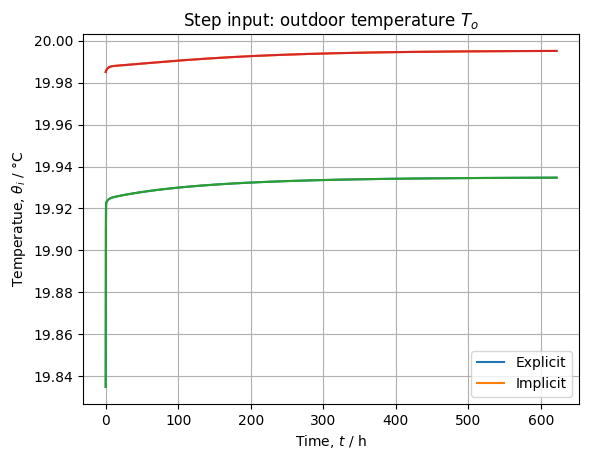

In [3229]:
#Results and Plot
fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time, $t$ / h',
       ylabel='Temperatue, $θ_i$ / °C',
       title='Step input: outdoor temperature $T_o$')
ax.legend(['Explicit', 'Implicit'])
ax.grid()
plt.show()

As shown in the figure above, bothe implicit and explicit results are quite identical.

In [3230]:
#The value the indoor temperature obtained after the settling time is almost equal to the value obtained in steady-state.
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: Room 1: {float(θ[5]):.4f}, Room 2: {float(θ[10]):.4f} °C')
print(f'- state-space model: Room 1: {float(yss[0]):.4f}, Room 2: {float(yss[1]):.4f} °C')
print(f'- steady-state response to step input: Room 1: {float(y_exp[0, -2]):.4f}, Room 2: {float(y_exp[1, -2]):.4f} °C')

Steady-state indoor temperature obtained with:
- DAE model: Room 1: 19.9348, Room 2: 19.9796 °C
- state-space model: Room 1: 19.9348, Room 2: 19.9796 °C
- steady-state response to step input: Room 1: 19.9347, Room 2: 19.9952 °C


The results show a error around `1 °C`, which is an acceptable result. 

### Simulation with weather data

#### Start and end time
The simulation will be done from `start_date` to `end_date` indicated in the format `MM-DD HH:MM:SS` (month, day, hour:minute:second).

In [3231]:
start_date = '01-03 12:00:00'
end_date = '02-05 18:00:00'

The weather data are for a year. The choice of `2000` for the year is arbitrary; it used in order to respect the format `YYYY-MM-DD HH:MM:SS`.

In [3232]:
start_date = '2000-' + start_date
end_date = '2000-' + end_date
print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')

2000-01-03 12:00:00 	start date
2000-02-05 18:00:00 	end date


#### Inputs
##### Read weather data
Dynamic simulation needs [time series](https://en.m.wikipedia.org/wiki/Time_series) of weather data for air temperature, direct solar radiation on a normal surface and diffuse solar radiation on an horizontal surface (see the tutorial on [Weather data and solar radiation](../t01/t01ReadWeatherData.ipynb)).

In [3233]:
filename = './weather_data/FRA_Lyon.074810_IWEC.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

From the weather data, we select:
- hourly outdoor air temperature, °C;
- hourly solar [direct normal irradiance](https://en.m.wikipedia.org/wiki/Direct_insolation) (or beam radiation), W/m²;
- hourly solar diffuse horizontal irradiance (or [diffuse sky radiation](https://en.wikipedia.org/wiki/Diffuse_sky_radiation)), W/m²,

from the start to the end date.

In [3234]:
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]

##### Solar irradiance on the walls
For the surface orientation given by `slope`, `azimuth`and `latitude`, and the `albedo` of the surface in front of the wall, by using the weather data, we can calculate the:
- direct irradiance, W/m²,
- diffuse irradiance, W/m²,
- reflected irradiance, W/m²,

for hourly solar [irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance) on a tilted surface.

In [3235]:
surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, albedo)
# pd.DataFrame(rad_surf)

The total solar [irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance)  $E_{tot}$, in W/m², is the sum of direct, diffuse, and reflected components. 

In [3236]:
rad_surf['Φtot'] = rad_surf.sum(axis=1)

##### Resample the weather data
The weather data is at the time-step of 1h. It needs to be resampled at time step $\Delta t$ used for numerical integration.

In [3237]:
# resample weather data
data = pd.concat([weather['temp_air'], rad_surf['Φtot']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})
# pd.DataFrame(data)
#print(rad_surf)

##### Other inputs
Let's consider the indoor temperature setpoint $T_{i,sp} = 20 \, \mathrm{^\circ C}$ and the auxiliary heat flow $\dot{Q}_a = 0 \, \mathrm{W}$ constant for the whole duration of the simulation.

In [3238]:
data['Ti'] = 20 * np.ones(data.shape[0])
data['Qa'] = 0 * np.ones(data.shape[0])
# pd.DataFrame(data)

##### Input vector in time
The input is formed by the vectors of time series of temperature sources $\left [ T_o, T_o ,T_o, T_{i,sp} \right ]^T$ and vectors of time series of the heat flow sources $\left [ \Phi_o, \Phi_i, \dot{Q_a}, \Phi_a \right ]^T$:

$$u = 
\begin{bmatrix}
T_o\\ 
T_o\\ 
T_o\\ 
T_{i,sp}\\ 
\Phi_o\\ 
\Phi_i\\ 
\dot{Q}_a\\ 
\Phi_a
\end{bmatrix}
= \begin{bmatrix}
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
 T_{i,sp(0)} & T_{i,sp(1)}& ... & T_{i,sp(n-1)}\ \\ 
\Phi_{o,(0)} & \Phi_{o,(1)} & ... & \Phi_{o,(n-1)}\\
\Phi_{i,(0)} & \Phi_{i,(1)} & ... & \Phi_{i,(n-1)}\\ 
 \dot{Q}_{a(0)} & \dot{Q}_{a(1)} & ... & \dot{Q}_{a(n-1)}\\ 
\Phi_{a,(0)} & \Phi_{a,(1)} & ... & \Phi_{a,(n-1)}
\end{bmatrix}$$

where:

$T_o$: the time series vector of outdoor temperatures (from weather data), °C.

$T_{i,sp}$: time series vector of indoor setpoint temperatures, °C.

$\Phi_o$: time series vector of solar (i.e. short wave) radiation, in W, absorbed by the outdoor surface of the wall:

$$\Phi_o = \alpha_{w,SW} S_w E_{tot}$$

where:

- $\alpha_{w,SW}$ is the absortion coefficient of the outdoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_w$ - surface area of the wall, m²;
- $E_{tot}$ - total solar irradiation on the wall, W/m².

$\Phi_i$: time series vector of short wave (i.e. solar) radiation, in W, absorbed by the indoor surfaces of the wall:

$$\Phi_i = \tau_{g,SW}  \alpha_{w,SW} S_g E_{tot}$$

where:
- $\tau_{g,SW}$ is the transmission coefficient of the window glass, $0 \leqslant \tau_{g,SW} \leqslant 1$;
- $\alpha_{w,SW}$ - absortion coefficient of the indoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_g$ - surface area of the window glass, m²;
- $E_{tot}$ - total solar radiation intensity on the wall, W/m².

$\dot{Q}_a$: time vector of auxiliary heat flows (from occupants, electrical devices, etc.), W.

$\Phi_a$: time series vector of short wave (i.e. solar) radiation, in W, absorbed by the window glass:

$$\Phi_a = \alpha_{g,SW} S_g E_{tot}$$

where:
- $\alpha_{g,SW}$ is the absortion coefficient of the glass window in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_g$ - surface area of the glass window, m²;
- $E_{tot}$ - total solar irradiation on the wall, W/m².

In [3239]:
#Input vector in time
# input vector
To = data['To']
Ti = data['Ti']
Φo1 = α_wSW * wall_out_1['Surface']['Layer_out'] * data['Φtot']
Φo2= α_wSW * wall_out_1['Surface']['Layer_out'] * data['Φtot']
Φo3 = α_wSW * wall_out_2['Surface']['Layer_out'] * data['Φtot']
Φo4= α_wSW * wall_out_2['Surface']['Layer_out'] * data['Φtot']
Φa1=α_gSW * wall_out_1['Surface']['Glass'] * data['Φtot']
Φa2=α_gSW * wall_out_2['Surface']['Glass'] * data['Φtot']
Φi1 = τ_gSW * α_wSW * wall_out_1['Surface']['Glass'] * data['Φtot']
Φi2 = τ_gSW * α_wSW * wall_out_2['Surface']['Glass'] * data['Φtot']


#Heat sources 
u = pd.concat([To, Ti, To, To, Ti, Ti, To, To, Φo1, Φo2, Φo3, Φo4,Φi1,Φi2, Φa1, Φa2 ], axis=1)
u.columns.values[[8,9,10,11,12,13,14,15]] = ['Φo1', 'Φo2','Φo3', 'Φo4','Φi1','Φi2', 'Φa1', 'Φa2']
pd.DataFrame(u)

,To,Ti,To,To,Ti,Ti,To,To,Φo1,Φo2,Φo3,Φo4,Φi1,Φi2,Φa1,Φa2
2000-01-03 12:00:00+01:00,6.800000,20.0,6.800000,6.800000,20.0,20.0,6.800000,6.800000,316.638781,316.638781,301.796338,301.796338,20.779420,20.779420,105.282395,105.282395
2000-01-03 12:05:00+01:00,6.900000,20.0,6.900000,6.900000,20.0,20.0,6.900000,6.900000,335.949389,335.949389,320.201762,320.201762,22.046679,22.046679,111.703172,111.703172
2000-01-03 12:10:00+01:00,7.000000,20.0,7.000000,7.000000,20.0,20.0,7.000000,7.000000,355.259997,355.259997,338.607185,338.607185,23.313937,23.313937,118.123949,118.123949
2000-01-03 12:15:00+01:00,7.100000,20.0,7.100000,7.100000,20.0,20.0,7.100000,7.100000,374.570605,374.570605,357.012608,357.012608,24.581196,24.581196,124.544726,124.544726
2000-01-03 12:20:00+01:00,7.200000,20.0,7.200000,7.200000,20.0,20.0,7.200000,7.200000,393.881213,393.881213,375.418031,375.418031,25.848455,25.848455,130.965503,130.965503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-02-05 17:40:00+01:00,8.866667,20.0,8.866667,8.866667,20.0,20.0,8.866667,8.866667,8.960000,8.960000,8.540000,8.540000,0.588000,0.588000,2.979200,2.979200
2000-02-05 17:45:00+01:00,8.725000,20.0,8.725000,8.725000,20.0,20.0,8.725000,8.725000,6.720000,6.720000,6.405000,6.405000,0.441000,0.441000,2.234400,2.234400
2000-02-05 17:50:00+01:00,8.583333,20.0,8.583333,8.583333,20.0,20.0,8.583333,8.583333,4.480000,4.480000,4.270000,4.270000,0.294000,0.294000,1.489600,1.489600
2000-02-05 17:55:00+01:00,8.441667,20.0,8.441667,8.441667,20.0,20.0,8.441667,8.441667,2.240000,2.240000,2.135000,2.135000,0.147000,0.147000,0.744800,0.744800


#### Initial conditions
The initial value of the state-vector can be zero or different from zero.

In [3240]:
θ_exp = 20 * np.ones([As.shape[0], u.shape[0]])

#### Time integration
[Explicit Euler](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) integration in time,

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

where $k = 0, ... , n - 1$,

In [3241]:
for k in range(u.shape[0] - 1):
    θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]


yields the time variation of state variable $\theta$, from which we obtain the variation of the output (i.e. indoor temperature):

$$y = C_s \theta_s + D_s u$$

and the variation of the heat flow of the HVAC system:

$$q_{HVAC} = K_p (T_{i,sp} - \theta_i) = K_p (T_{i,sp} - y)$$

where $K_p$ is the gain of the P-controller and $T_{i,sp}$ is the HVAC-setpoint for the indoor temperature.

In [3242]:
y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T
q_HVAC = Kp * (data['Ti'] - y_exp[0, :])


In [3243]:
data['θi_exp1'] = y_exp.T[:,0]
data['θi_exp2']=y_exp.T[:,1]
data['q_HVAC'] = q_HVAC.T


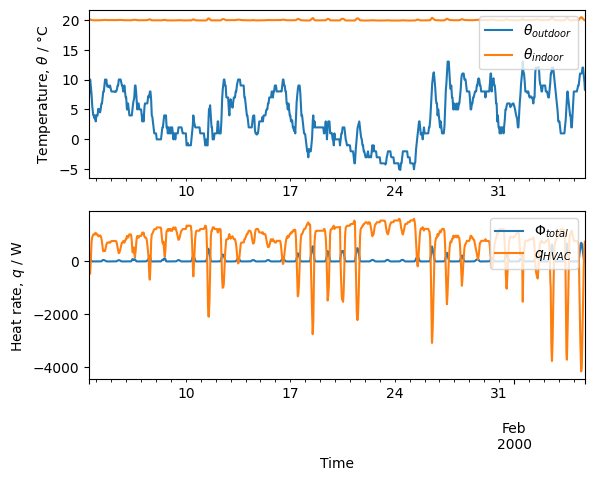

In [3244]:
fig, axs = plt.subplots(2, 1)

data[['To', 'θi_exp1']].plot(ax=axs[0],
                            xticks=[],
                            ylabel='Temperature, $θ$ / °C')
axs[0].legend(['$θ_{outdoor}$', '$θ_{indoor}$'],
              loc='upper right')

data[['Φtot', 'q_HVAC']].plot(ax=axs[1],
                              ylabel='Heat rate, $q$ / W')
axs[1].set(xlabel='Time')
axs[1].legend(['$Φ_{total}$', '$q_{HVAC}$'],
             loc='upper right')
plt.show()

> Figure 6. Simulation in free-running with weather data using Euler explicit method of integration. a) Indoor and outdoor temperatures. b) Solar and HVAC heat flow rates.

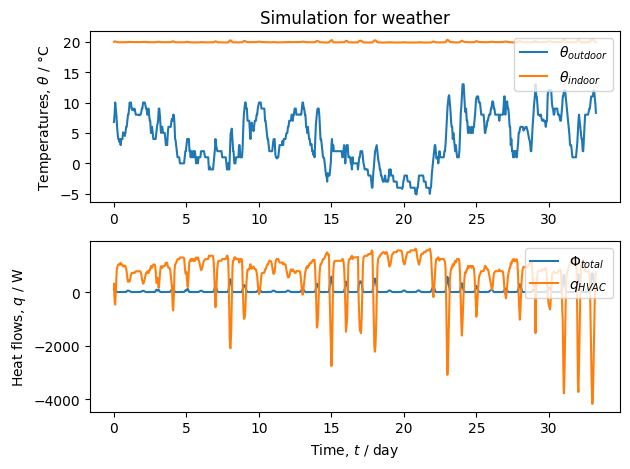

In [3245]:
t = dt * np.arange(data.shape[0])   # time vector

fig, axs = plt.subplots(2, 1)
# plot outdoor and indoor temperature
axs[0].plot(t / 3600 / 24, data['To'], label='$θ_{outdoor}$')
axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$θ_{indoor}$')
axs[0].set(ylabel='Temperatures, $θ$ / °C',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600 / 24, data['Φtot'], label='$Φ_{total}$')
axs[1].plot(t / 3600 / 24, q_HVAC, label='$q_{HVAC}$')
axs[1].set(xlabel='Time, $t$ / day',
           ylabel='Heat flows, $q$ / W')
axs[1].legend(loc='upper right')

fig.tight_layout()

> Figure 7. Simulation in free-running with weather data using Euler explicit method of integration. a) Indoor and outdoor temperatures. b) Solar and HVAC heat flow rates.

### Conclusions and perspectives
As learned in the course we understood that the implicit Euler method  is more accurate and stable, but it requires solving an equation at each time step, making it computationally more costly. Explicit Euler is straightforward and less computationally expensive, but it can also be less accurate and less stable. For our case, the results are almost identical. Corroborating with the theory, the implicit method shows better results. 

Studying our model in state representation allowed us to study the heat transfer phenomena, as a linear, time-invariant system. This in turn requires the numerical stability of the Euler explicit integration. If not, our model validation and reproducibility could be questionable. The amount of time it takes for a thermal system to respond to a step input by reaching 63.2% of its final steady-state value is referred to as the desired time constant. The eigenvalues of the state matrix A are connected to this time constant. For this reason, the manual construction of the matrices and vector for a state-space representation needs to be diligently done, otherwise, all the system will not provide valid and relevant data. 

It is interesting to note that this model has the potential to understand the overall thermal behavior of a 2-room inside a building under specific weather conditions. On the other hand, it presents several limitations. The assumptions made are noy strictly related to simulate the real system. In order to improve the accuracy of the model, it will be necessary to take into account various heat transportation phenomena. Thus, our thermal circuit will become much more complex than it is now. 

Finally, the results obtained show that a 2-rooms inside a building can be controlled by an energy intensive HVAC system. The thermal circuit thermal behavior is validated, giving a modest model for controlling the temperature inside a room under variations in weather data conditions.


As shown in the graphs, the HVAC system, simulated as a perfect proportional controller, controls the temperature accurately, with almost no error, neither in steady state and under abrupt perturbations. However, in real life, having mechanical ventilation with these characteristics  will significantly consume energy. For the building thermal modeling discipline, one of its objectives is to improve the overall energy efficiency of the building. 


## References

1. C. Ghiaus (2013) Causality issue in the heat balance method for calculating the design heating and cooling loads, *Energy* 50: 292-301, https://doi.org/10.1016/j.energy.2012.10.024, open access preprint: [hal-03605823](https://hal.archives-ouvertes.fr/hal-03605823/document)

2. J.A. Duffie, W. A. Beckman, N. Blair (2020) [Solar Engineering of Thermal Processes](https://www.eng.uc.edu/~beaucag/Classes/SolarPowerForAfrica/Solar%20Engineering%20of%20Thermal%20Processes,%20Photovoltaics%20and%20Wind.pdf), 5th ed. John Wiley & Sons, Inc. ISBN 9781119540281

3. [Réglementation Thermique 2005. Méthode de calcul Th-CE.](https://pdfslide.fr/documents/rt2005-methode-de-calcul-th-ce.html) Annexe à l’arrêté du 19 juillet 2006

4. H. Recknagel, E. Sprenger, E.-R. Schramek (2013) Génie climatique, 5e edition, Dunod, Paris. ISBN 978-2-10-070451-4

5. J.R. Howell et al. (2021) Thermal Radiation Heat Transfer 7th edition, ISBN 978-0-367-34707-0, [A Catalogue of Configuration Factors](http://www.thermalradiation.net/indexCat.html)

6. J. Widén, J. Munkhammar (2019) [Solar Radiation Theory](http://www.diva-portal.org/smash/get/diva2:1305017/FULLTEXT01.pdf), Uppsala University